# Imports

In [2]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

In [18]:
from dataclasses import dataclass

from src.mutant import Mutant
from src.execution import Execution




In [243]:
def generate_repo_diff_data(repo: Repo, mutant_id=-1):
    current_diff = repo.index.diff(None)
    diff = repo.git.diff(repo.head, None)
    patchset = PatchSet(diff)
    
    print(patchset[0].target_file)
    modified_file_path = patchset[0].target_file[2:] # Remove b/ from the path
    changed_sourcecode_line = patchset[0][0].source_start
    previous_line = ''
    change_to_line = ''
    for line in patchset[0][0]:
        if line.is_added:
            changed_to_line = str(line)[2:]
        if line.is_removed:
            previous_line = str(line)[2:]
    
    return Mutant(mutant_id, modified_file_path, changed_sourcecode_line, previous_line, changed_to_line)

#print(analyze_change_in_working_directory(repo).__dict__)

In [244]:
def generate_test_data(mutant_id=-1):
    with open('repos/flask/report.json') as json_file:
        data = json.load(json_file)["report"]
#         print(json.dumps(data, indent=2))
        test_runs = []
        for json_test in data["tests"]:
             test_runs.append(Test.fromJson(json_test))
        return test_runs
        

In [250]:
!cd repos/flask/ && pytest --json=report.json --timeout=300

============================= test session starts ==============================
platform linux -- Python 3.8.1, pytest-5.4.2, py-1.8.1, pluggy-0.13.1
rootdir: /mnt/brick/home/dmeier/CRM2020/repos/flask, inifile: setup.cfg, testpaths: tests
plugins: timeout-1.3.4, json-report-1.2.1, json-0.4.0, metadata-1.9.0
timeout: 300.0s
timeout method: signal
timeout func_only: False
collected 468 items                                                            

tests/test_appctx.py ..............                                      [  2%]
tests/test_basic.py .................................................... [ 14%]
......................................................................   [ 29%]
tests/test_blueprints.py ............................................... [ 39%]
.                                                                        [ 39%]
tests/test_cli.py .........................................ss.s......    [ 50%]
tests/test_config.py ................                           

In [251]:
with open('repos/flask/report.json') as json_file:
    print(json.load(json_file)["report"]["tests"][0])

{'name': 'tests/test_appctx.py::test_basic_url_generation', 'duration': 0.004573345184326172, 'run_index': 0, 'setup': {'name': 'setup', 'duration': 0.0018436908721923828, 'outcome': 'passed'}, 'call': {'name': 'call', 'duration': 0.0006525516510009766, 'outcome': 'passed'}, 'teardown': {'name': 'teardown', 'duration': 0.0002334117889404297, 'outcome': 'passed'}, 'outcome': 'passed'}


In [245]:
mutants = pd.DataFrame(columns=['mutant_id','modified_file_path','line_number_changed','previous_line', 'current_line'])
mutants
test_runs = pd.DataFrame(columns=['test_id', 'mutant_id', 'outcome'])

"failed" == "failed"

True

In [246]:
def analyze_mutant(*,mutant_id):
    repo = Repo("repos/flask")
    assert not repo.bare
    !echo Switching to Mutant $mutant_id
    !. crm2020_python3.8/bin/activate && cd repos/flask/ && mutmut apply $mutant_id && pytest --json=report.json > /dev/null
    changed_file = generate_repo_diff_data(repo= repo, mutant_id=mutant_id)
    tests = generate_test_data(mutant_id=mutant_id)
    
    # Cleanup logic:
    !cd repos/flask/ && git checkout .
    !rm repos/flask/report.json
    
    return {"changed_file": changed_file, "tests": tests}
    
# analyze_mutant(mutant_id=1)

In [247]:
tests = pd.DataFrame(columns=Test.__annotations__)
mutants = pd.DataFrame(columns=Mutant.__annotations__)

for mutant_id in range(1, 2, 1):
    try:
        results = analyze_mutant(mutant_id=mutant_id)
        for test in results["tests"]:
            tests = tests.append(test.__dict__, ignore_index = True)
        mutants = mutants.append(results["changed_file"].__dict__, ignore_index=True)
        print("Tests length: " + str(len(tests)))
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print("Resetting the repo and then testing the next mutant")
        !cd repos/flask/ && git checkout .


Switching to Mutant 1
b/src/flask/app.py
Tests length: 468


In [248]:
tests

,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
0,True,0,tests/test_appctx.py::test_basic_url_generation,test_basic_url_generation,tests/test_appctx.py,0.003975,True,0.001587,True,0.000592947,True,0.000208378
1,True,1,tests/test_appctx.py::test_url_generation_requ...,test_url_generation_requires_server_name,tests/test_appctx.py,0.002659,True,0.001115,True,0.000249624,True,0.000180483
2,True,2,tests/test_appctx.py::test_url_generation_with...,test_url_generation_without_context_fails,tests/test_appctx.py,0.000828,True,0.000251,True,0.000160456,True,0.000165462
3,True,3,tests/test_appctx.py::test_request_context_mea...,test_request_context_means_app_context,tests/test_appctx.py,0.002968,True,0.001097,True,0.00058341,True,0.000190258
4,True,4,tests/test_appctx.py::test_app_context_provide...,test_app_context_provides_current_app,tests/test_appctx.py,0.003050,True,0.001356,True,0.000160694,True,0.000177145
...,...,...,...,...,...,...,...,...,...,...,...,...
463,True,463,tests/test_views.py::test_explicit_head,test_explicit_head,tests/test_views.py,0.004402,True,0.001329,True,0.00151491,True,0.000228882
464,True,464,tests/test_views.py::test_endpoint_override,test_endpoint_override,tests/test_views.py,0.005579,True,0.001246,True,0.00287104,True,0.000215054
465,True,465,tests/test_views.py::test_methods_var_inheritance,test_methods_var_inheritance,tests/test_views.py,0.004526,True,0.001351,True,0.00158238,True,0.000241995
466,True,466,tests/test_views.py::test_multiple_inheritance,test_multiple_inheritance,tests/test_views.py,0.005246,True,0.001344,True,0.00232792,True,0.000229597


In [249]:
mutants

,mutant_id,modified_file_path,line_number_changed,previous_line,current_line
0,1,src/flask/app.py,54,sentinel = object()\n,sentinel = None\n


In [ ]:
mutants_and_tests = mutants.set_index('mutant_id').join(tests.set_index('mutant_id'))
# mutants_and_tests.to_pickle('flask_dataset_every_mutant_with_checkout_on_failure.pkl')

In [ ]:
mutants_and_tests.groupby(['test_id','outcome']).count()['current_line']


In [74]:
# Covariance Matrix 
mutants_and_tests = pd.read_pickle('20200604-001227joined_data')
mutants_and_tests.reset_index()
mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
mutants_and_tests["outcome"].loc[mutants_and_tests["outcome"] == False]

mutant_id
1       False
1       False
1       False
1       False
1       False
        ...  
1234    False
1234    False
1234    False
1234    False
1234    False
Name: outcome, Length: 84, dtype: bool

,modified_file_path,line_number_changed,previous_line,current_line,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
mutant_id,,,,,,,,,,,,,,,,
1,src/flask/config.py,9,,self.__name__ = None\n,True,0,tests/test_appctx.py::test_basic_url_generation,test_basic_url_generation,tests/test_appctx.py,0.007523,True,0.003278,True,0.000736,True,0.000231
1,src/flask/config.py,9,,self.__name__ = None\n,True,1,tests/test_appctx.py::test_url_generation_requ...,test_url_generation_requires_server_name,tests/test_appctx.py,0.003607,True,0.001565,True,0.000260,True,0.000216
1,src/flask/config.py,9,,self.__name__ = None\n,True,2,tests/test_appctx.py::test_url_generation_with...,test_url_generation_without_context_fails,tests/test_appctx.py,0.000993,True,0.000324,True,0.000161,True,0.000185
1,src/flask/config.py,9,,self.__name__ = None\n,True,3,tests/test_appctx.py::test_request_context_mea...,test_request_context_means_app_context,tests/test_appctx.py,0.004140,True,0.001608,True,0.000709,True,0.000215
1,src/flask/config.py,9,,self.__name__ = None\n,True,4,tests/test_appctx.py::test_app_context_provide...,test_app_context_provides_current_app,tests/test_appctx.py,0.003985,True,0.001772,True,0.000204,True,0.000237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,463,tests/test_views.py::test_explicit_head,test_explicit_head,tests/test_views.py,0.005416,True,0.001683,True,0.001799,True,0.000251
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,464,tests/test_views.py::test_endpoint_override,test_endpoint_override,tests/test_views.py,0.006971,True,0.001561,True,0.003595,True,0.000255
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,465,tests/test_views.py::test_methods_var_inheritance,test_methods_var_inheritance,tests/test_views.py,0.005810,True,0.001828,True,0.001915,True,0.000239


test_id,1,2,3,4,5,6,7,8,9,10,...,458,459,460,461,462,463,464,465,466,467
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
1869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [79]:
pivot = pivot.astype('bool')

test_id,1,2,3,4,5,6,7,8,9,10,...,458,459,460,461,462,463,464,465,466,467
test_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


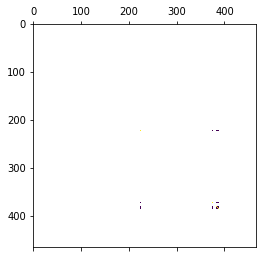

In [6]:
display(pivot.cov())

plt.matshow(pivot.corr())
plt.show()

,index,mutant_id,current_line,line_number_changed,modified_file_path,previous_line,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
225,225,1.0,sentinel = None\n,54.0,src/flask/app.py,,False,225,tests/test_cli.py::test_load_dotenv,test_load_dotenv,tests/test_cli.py,0.000375,False,0.000130,None,NaN,None,NaN
226,226,1.0,sentinel = None\n,54.0,src/flask/app.py,,False,226,tests/test_cli.py::test_dotenv_path,test_dotenv_path,tests/test_cli.py,0.000386,False,0.000138,None,NaN,None,NaN
228,228,1.0,sentinel = None\n,54.0,src/flask/app.py,,False,228,tests/test_cli.py::test_disable_dotenv_from_env,test_disable_dotenv_from_env,tests/test_cli.py,0.000340,False,0.000114,None,NaN,None,NaN
375,375,1.0,sentinel = None\n,54.0,src/flask/app.py,,False,375,tests/test_reqctx.py::TestGreenletContextCopyi...,TestGreenletContextCopying::test_greenlet_cont...,tests/test_reqctx.py,0.000507,False,0.000186,None,NaN,None,NaN
376,376,1.0,sentinel = None\n,54.0,src/flask/app.py,,False,376,tests/test_reqctx.py::TestGreenletContextCopyi...,TestGreenletContextCopying::test_greenlet_cont...,tests/test_reqctx.py,0.000416,False,0.000142,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467917,467917,1000.0,"ppcontext_tearing_down = _signals.signal(""XXap...",48.0,src/flask/signals.py,,False,385,tests/test_signals.py::test_request_exception_...,test_request_exception_signal,tests/test_signals.py,0.000406,False,0.000137,None,NaN,None,NaN
467918,467918,1000.0,"ppcontext_tearing_down = _signals.signal(""XXap...",48.0,src/flask/signals.py,,False,386,tests/test_signals.py::test_appcontext_signals,test_appcontext_signals,tests/test_signals.py,0.000431,False,0.000143,None,NaN,None,NaN
467919,467919,1000.0,"ppcontext_tearing_down = _signals.signal(""XXap...",48.0,src/flask/signals.py,,False,387,tests/test_signals.py::test_flash_signal,test_flash_signal,tests/test_signals.py,0.000401,False,0.000138,None,NaN,None,NaN
467920,467920,1000.0,"ppcontext_tearing_down = _signals.signal(""XXap...",48.0,src/flask/signals.py,,False,388,tests/test_signals.py::test_appcontext_tearing...,test_appcontext_tearing_down_signal,tests/test_signals.py,0.000404,False,0.000134,None,NaN,None,NaN


test_id,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
test_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001000,0.0,...,0.001000,0.001000,0.001000,0.000999,0.001000,0.001000,0.000999,0.001000,0.001000,0.001000
464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000999,0.0,...,0.000999,0.000999,0.000999,0.000997,0.000999,0.000999,0.001998,0.000999,0.000999,0.000999
465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001000,0.0,...,0.001000,0.001000,0.001000,0.000999,0.001000,0.001000,0.000999,0.001000,0.001000,0.001000


DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBU

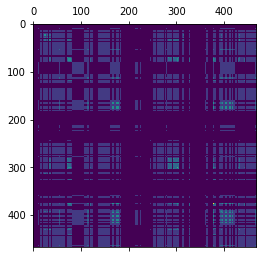

In [13]:
mutants_and_tests = pd.read_pickle('20200604-231426_flask_range_1_1000.pkl').reset_index()
display(mutants_and_tests.loc[mutants_and_tests['outcome'] == False])
pivot = mutants_and_tests.reset_index().pivot(index='mutant_id', columns='test_id', values='outcome')
# pivot.drop(pivot.columns[0], axis=1, inplace=True)
display(pivot.cov(min_periods=12))
plt.matshow(pivot.cov())
plt.show()

In [ ]:
# import pandas as pd
import logging

from src.data_analysis import DataAnalysis
from src.data_crawler import DataCrawler
from src.execution import Execution
from src.mutant import Mutant

logging.basicConfig(level=logging.INFO)

data_analysis = DataAnalysis('repos/jinja', 'repos/flask/env')


data_analysis.collect_data(range(1, 4958, 1))
data_analysis.store_data_to_disk('jinja_range_1_4959')

print(data_analysis.executions[data_analysis.executions['outcome'] == False])

INFO:root:Temporary directory now contains:
INFO:root:['setup.cfg', 'LICENSE.rst', 'src', 'artwork', '.github', '.mutmut-cache', 'docs', '.git', '.editorconfig', 'tests', 'README.rst', 'requirements', 'MANIFEST.in', 'setup.py', 'CODE_OF_CONDUCT.md', '.readthedocs.yaml', '.gitignore', 'CHANGES.rst', 'scripts', '.pytest_cache', '.pre-commit-config.yaml', 'tox.ini', 'examples']
INFO:root:['setup.cfg', 'LICENSE.rst', 'src', 'artwork', '.github', '.mutmut-cache', 'docs', '.git', '.editorconfig', 'tests', 'README.rst', 'requirements', 'MANIFEST.in', 'setup.py', 'CODE_OF_CONDUCT.md', '.readthedocs.yaml', '.gitignore', 'CHANGES.rst', 'scripts', '.pytest_cache', '.pre-commit-config.yaml', 'tox.ini', 'examples']
INFO:root:Switching to Mutant 1


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 1


INFO:root:Executing tests for Mutant 1
INFO:root:Switching to Mutant 2


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 2


INFO:root:Executing tests for Mutant 2
INFO:root:Switching to Mutant 3


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 3


INFO:root:Executing tests for Mutant 3
INFO:root:Switching to Mutant 4


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 4


INFO:root:Executing tests for Mutant 4
INFO:root:Switching to Mutant 5


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 5


INFO:root:Executing tests for Mutant 5
INFO:root:Switching to Mutant 6


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 6


INFO:root:Executing tests for Mutant 6
INFO:root:Switching to Mutant 7


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 7


INFO:root:Executing tests for Mutant 7
INFO:root:Switching to Mutant 8


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 8


INFO:root:Executing tests for Mutant 8
INFO:root:Switching to Mutant 9


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 9


INFO:root:Executing tests for Mutant 9
INFO:root:Switching to Mutant 10


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 10


INFO:root:Executing tests for Mutant 10
INFO:root:Switching to Mutant 11


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 11


INFO:root:Executing tests for Mutant 11
INFO:root:Switching to Mutant 12


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 12


INFO:root:Executing tests for Mutant 12
INFO:root:Switching to Mutant 13


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 13


INFO:root:Executing tests for Mutant 13
INFO:root:Switching to Mutant 14


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 14


INFO:root:Executing tests for Mutant 14
INFO:root:Switching to Mutant 15


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 15


INFO:root:Executing tests for Mutant 15
INFO:root:Switching to Mutant 16


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 16


INFO:root:Executing tests for Mutant 16
INFO:root:Switching to Mutant 17


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 17


INFO:root:Executing tests for Mutant 17
INFO:root:Switching to Mutant 18


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 18


INFO:root:Executing tests for Mutant 18
INFO:root:Switching to Mutant 19


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 19


INFO:root:Executing tests for Mutant 19
INFO:root:Switching to Mutant 20


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 20


INFO:root:Executing tests for Mutant 20
INFO:root:Switching to Mutant 21


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 21


INFO:root:Executing tests for Mutant 21
INFO:root:Switching to Mutant 22


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 22


INFO:root:Executing tests for Mutant 22
INFO:root:Switching to Mutant 23


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 23


INFO:root:Executing tests for Mutant 23
INFO:root:Switching to Mutant 24


. repos/flask/env/bin/activate && cd /tmp/tmpuqe8uhmh && mutmut apply 24


INFO:root:Executing tests for Mutant 24


In [9]:
print(len(data_analysis.mutants))

1000


In [11]:
data_analysis.executions


,outcome,test_id,full_name,name,filepath,duration,mutant_id,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
0,True,0,tests/test_api.py::TestExtendedAPI::test_item_...,TestExtendedAPI::test_item_and_attribute,tests/test_api.py,0.069959,1,True,0.027196,True,0.015401,True,0.000166
1,True,1,tests/test_api.py::TestExtendedAPI::test_finalize,TestExtendedAPI::test_finalize,tests/test_api.py,0.001385,1,True,0.000200,True,0.000829,True,0.000157
2,True,2,tests/test_api.py::TestExtendedAPI::test_final...,TestExtendedAPI::test_finalize_constant_expres...,tests/test_api.py,0.001102,1,True,0.000200,True,0.000563,True,0.000139
3,True,3,tests/test_api.py::TestExtendedAPI::test_no_fi...,TestExtendedAPI::test_no_finalize_template_data,tests/test_api.py,0.001159,1,True,0.000195,True,0.000615,True,0.000154
4,True,4,tests/test_api.py::TestExtendedAPI::test_conte...,TestExtendedAPI::test_context_finalize,tests/test_api.py,0.001155,1,True,0.000213,True,0.000587,True,0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,True,748,tests/test_utils.py::TestLoremIpsum::test_lore...,TestLoremIpsum::test_lorem_ipsum_n,tests/test_utils.py,0.129584,3,True,0.000174,True,0.129078,True,0.000158
2255,True,749,tests/test_utils.py::TestLoremIpsum::test_lore...,TestLoremIpsum::test_lorem_ipsum_min,tests/test_utils.py,0.009121,3,True,0.000919,True,0.007151,True,0.000132
2256,True,750,tests/test_utils.py::TestLoremIpsum::test_lore...,TestLoremIpsum::test_lorem_ipsum_max,tests/test_utils.py,0.005411,3,True,0.000251,True,0.004780,True,0.000129
2257,True,751,tests/test_utils.py::test_missing,test_missing,tests/test_utils.py,0.000612,3,True,0.000162,True,0.000161,True,0.000127


In [3]:
d = pd.read_pickle('20200609-155911_dataframe.pkl')
d.groupby(['mutant_id', 'outcome']).count()

current_line  line_number_changed  modified_file_path  \
mutant_id outcome                                                          
1.0       False              23                   23                  23   
          True              445                  445                 445   
2.0       False              14                   14                  14   
          True              454                  454                 454   
3.0       False              13                   13                  13   
...                         ...                  ...                 ...   
313.0     True              455                  455                 455   
314.0     False              13                   13                  13   
          True              455                  455                 455   
315.0     False             209                  209                 209   
          True              259                  259                 259   

                   previous_line  test_id  full_name  name  filepath  \
mutant_id outcome                                                      
1.0       False               23       23         23    23        23   
          True               445      445        445   445       445   
2.0       False               14       14         14    14        14   
          True               454      454        454   454       454   
3.0       False               13       13         13    13        13   
...                          ...      ...        ...   ...       ...   
313.0     True               455      455        455   455       455   
314.0     False               13       13         13    13        13   
          True               455      455        455   455       455   
315.0     False              209      209        209   209       209   
          True               259      259        259   259       259   

                   duration  setup_outcome  setup_duration  call_outcome  \
mutant_id outcome                                                          
1.0       False          23             23              23            10   
          True          445            445             445           445   
2.0       False          14             14              14             1   
          True          454            454             454           454   
3.0       False          13             13              13             0   
...                     ...            ...             ...           ...   
313.0     True          455            455             455           455   
314.0     False          13             13              13             0   
          True          455            455             455           455   
315.0     False         209            209             209           196   
          True          259            259             259           259   

                   call_duration  teardown_outcome  teardown_duration  
mutant_id outcome                                                      
1.0       False               10                 0                  0  
          True               445               445                445  
2.0       False                1                 0                  0  
          True               454               454                454  
3.0       False                0                 0                  0  
...                          ...               ...                ...  
313.0     True               455               455                455  
314.0     False                0                 0                  0  
          True               455               455                455  
315.0     False              196                 0                  0  
          True               259               259                259  

[626 rows x 15 columns]